# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [5]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [6]:
display(station_dists)

{'GIARDINI MARGHERITA': {'NO2': {'mean': 17.136602996327458,
   'std': 12.587616590341343},
  'O3': {'mean': 48.99323253026026, 'std': 37.846167292629794},
  'PM10': {'mean': 22.191091954022987, 'std': 14.34740358417706},
  'PM2.5': {'mean': 14.040932889100429, 'std': 11.592741566776404}},
 'PORTA SAN FELICE': {'C6H6': {'mean': 0.968151707217338,
   'std': 0.7318637341961725},
  'CO': {'mean': 0.5782450785309969, 'std': 0.309891655957885},
  'NO2': {'mean': 39.71247258825127, 'std': 19.295279052188466},
  'PM10': {'mean': 25.275375939849624, 'std': 15.307084342757124},
  'PM2.5': {'mean': 15.601595495072736, 'std': 11.83142061990551}},
 'VIA CHIARINI': {'NO2': {'mean': 17.895650152999963,
   'std': 13.344157597945486},
  'O3': {'mean': 44.30852219807513, 'std': 38.50506210669337},
  'PM10': {'mean': 22.202087286527515, 'std': 13.572458621794096}}}

We can inspect the hourly and daily features:

In [213]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [214]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'day_sin', 'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3',
       'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_7',
       'month_rbf_8', 'month_rbf_9', 'month_rbf_10', 'month_rbf_11',
       'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

Our data covers 2019, ..., 2024. We decided to use 2024 as the test set.

In [215]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [216]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

In [217]:
train_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-1.088063,-1.801424,-0.137549,1.678544,-0.663642,-0.919936,0.883229,2.156313,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


In [218]:
train_sets['GIARDINI MARGHERITA']['NO2']['y'].head(1)

,Agent_value
Date,
2019-01-02,0.624693


## **Models**

We define different model architectures to try evaluate the pollutants.

A good result would be a certain architecture resulting in the best results for certain agents across all the stations, or even across all the agents.

Certain models will use sequences as input, for example LSTMs and Convolutional Networks.

The clear problem of this approach is the fact that it is really hard to find, while testing, a model able to work well with all the agents after being tested on a small part of the agents. We will of course be able to check if the model actually work nice on other agents, but it will most likely work very well just with the agents it has been tested on.

### **Hourly Models**

In [219]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [220]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [221]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [222]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [223]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(train_sets[station][agent]['x'], train_sets[station][agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

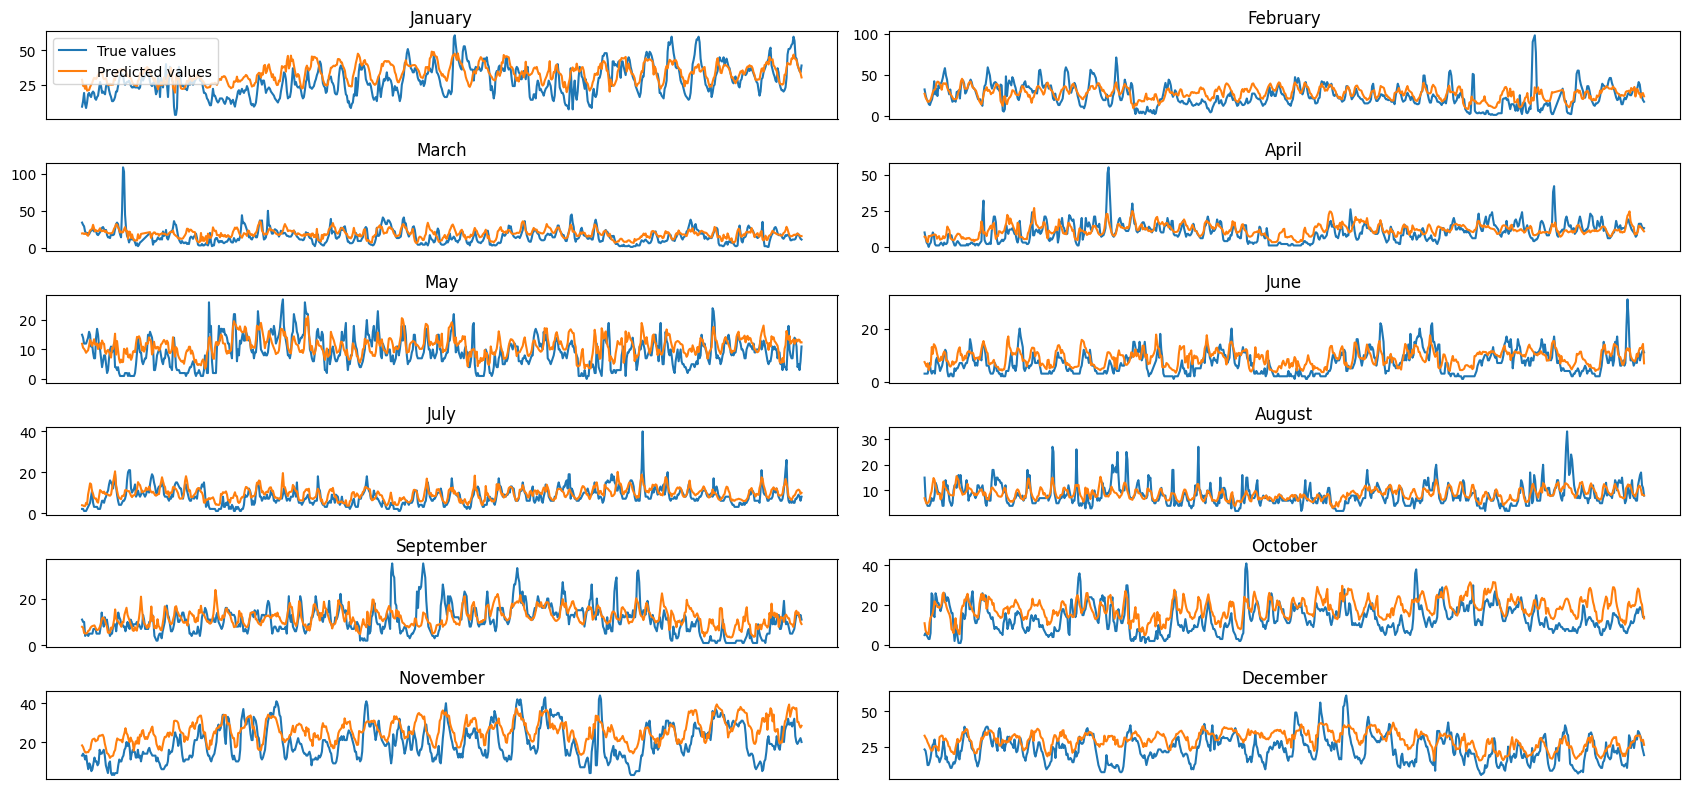

root_mean_squared_error: 0.589979964986232
r2_score: 0.5056268459985703
mean_absolute_error: 0.4381960740814996
huber: 0.06970956176519394


In [224]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost

##### *Models*

In [225]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [226]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [227]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [228]:
validation_ratio = 0.1

X_train, y_train = train_sets[station][agent]['x'], train_sets[station][agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.78181
[1]	validation_0-mae:0.74874
[2]	validation_0-mae:0.71971
[3]	validation_0-mae:0.69256
[4]	validation_0-mae:0.66813
[5]	validation_0-mae:0.64526
[6]	validation_0-mae:0.62481
[7]	validation_0-mae:0.60590
[8]	validation_0-mae:0.58933
[9]	validation_0-mae:0.57393
[10]	validation_0-mae:0.55997
[11]	validation_0-mae:0.54680
[12]	validation_0-mae:0.53537
[13]	validation_0-mae:0.52509
[14]	validation_0-mae:0.51525
[15]	validation_0-mae:0.50641
[16]	validation_0-mae:0.49883
[17]	validation_0-mae:0.49155
[18]	validation_0-mae:0.48513
[19]	validation_0-mae:0.47927
[20]	validation_0-mae:0.47405
[21]	validation_0-mae:0.46934
[22]	validation_0-mae:0.46442
[23]	validation_0-mae:0.46041
[24]	validation_0-mae:0.45655
[25]	validation_0-mae:0.45309
[26]	validation_0-mae:0.45008
[27]	validation_0-mae:0.44718
[28]	validation_0-mae:0.44442
[29]	validation_0-mae:0.44198
[30]	validation_0-mae:0.43970
[31]	validation_0-mae:0.43732
[32]	validation_0-mae:0.43556
[33]	validation_0-ma

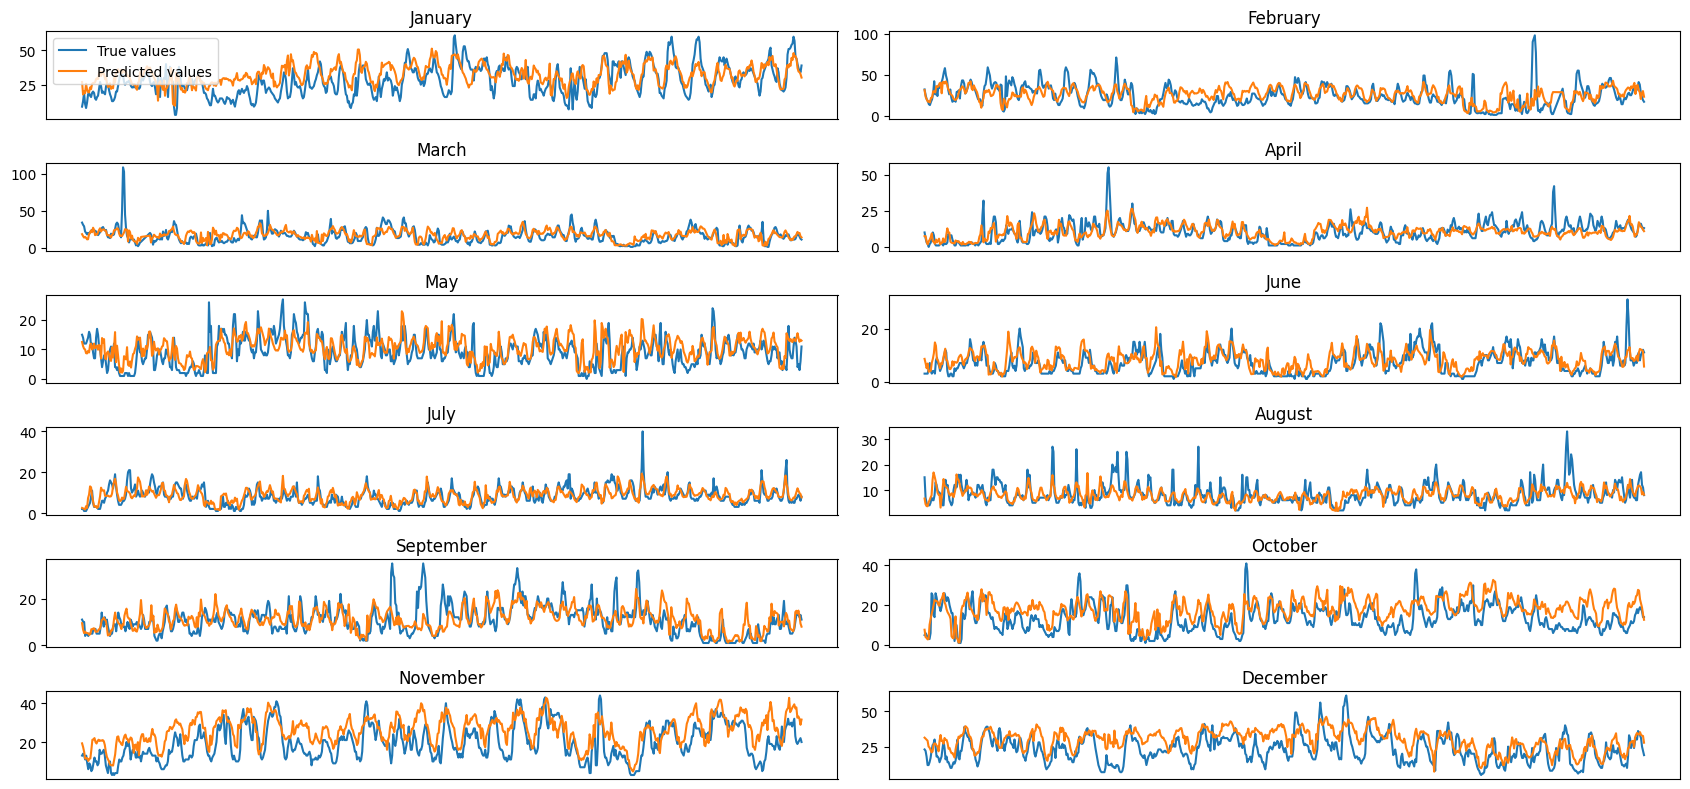

root_mean_squared_error: 0.5812921651275769
r2_score: 0.5200795120790505
mean_absolute_error: 0.41175752745989314
huber: 0.06502290070056915


In [229]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

##### *Models*

In [230]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [231]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=8e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':64,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [232]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [233]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [234]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM-masked'

In [235]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']
lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/50
601/601 [==============================] - 10s 10ms/step - loss: 0.4086 - val_loss: 0.3857
Epoch 2/50
601/601 [==============================] - 4s 7ms/step - loss: 0.3667 - val_loss: 0.3776
Epoch 3/50
601/601 [==============================] - 4s 7ms/step - loss: 0.3529 - val_loss: 0.3590
Epoch 4/50
601/601 [==============================] - 4s 7ms/step - loss: 0.3405 - val_loss: 0.3514
Epoch 5/50
601/601 [==============================] - 4s 7ms/step - loss: 0.3299 - val_loss: 0.3346
Epoch 6/50
601/601 [==============================] - 5s 8ms/step - loss: 0.3204 - val_loss: 0.3369
Epoch 7/50
601/601 [==============================] - 5s 8ms/step - loss: 0.3110 - val_loss: 0.3336
Epoch 8/50
601/601 [==============================] - 4s 7ms/step - loss: 0.3014 - val_loss: 0.3252
Epoch 9/50
601/601 [==============================] - 4s 7ms/step - loss: 0.2905 - val_loss: 0.3214
Epoch 10/50
601/601 [==============================] - 5s 8ms/step - loss: 0.2809 - val_loss: 0.32

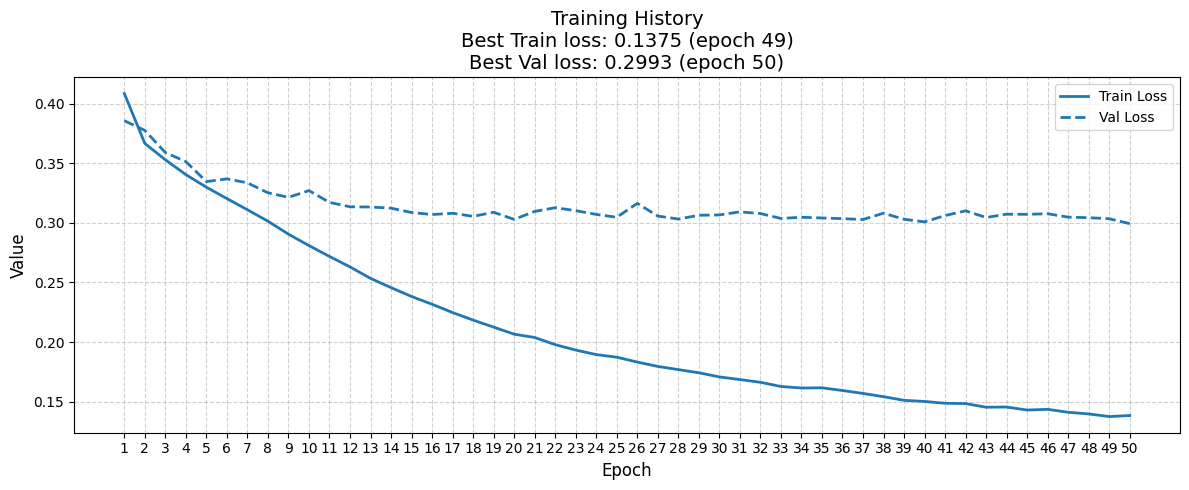

274/274 [==============================] - 2s 3ms/step


In [236]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

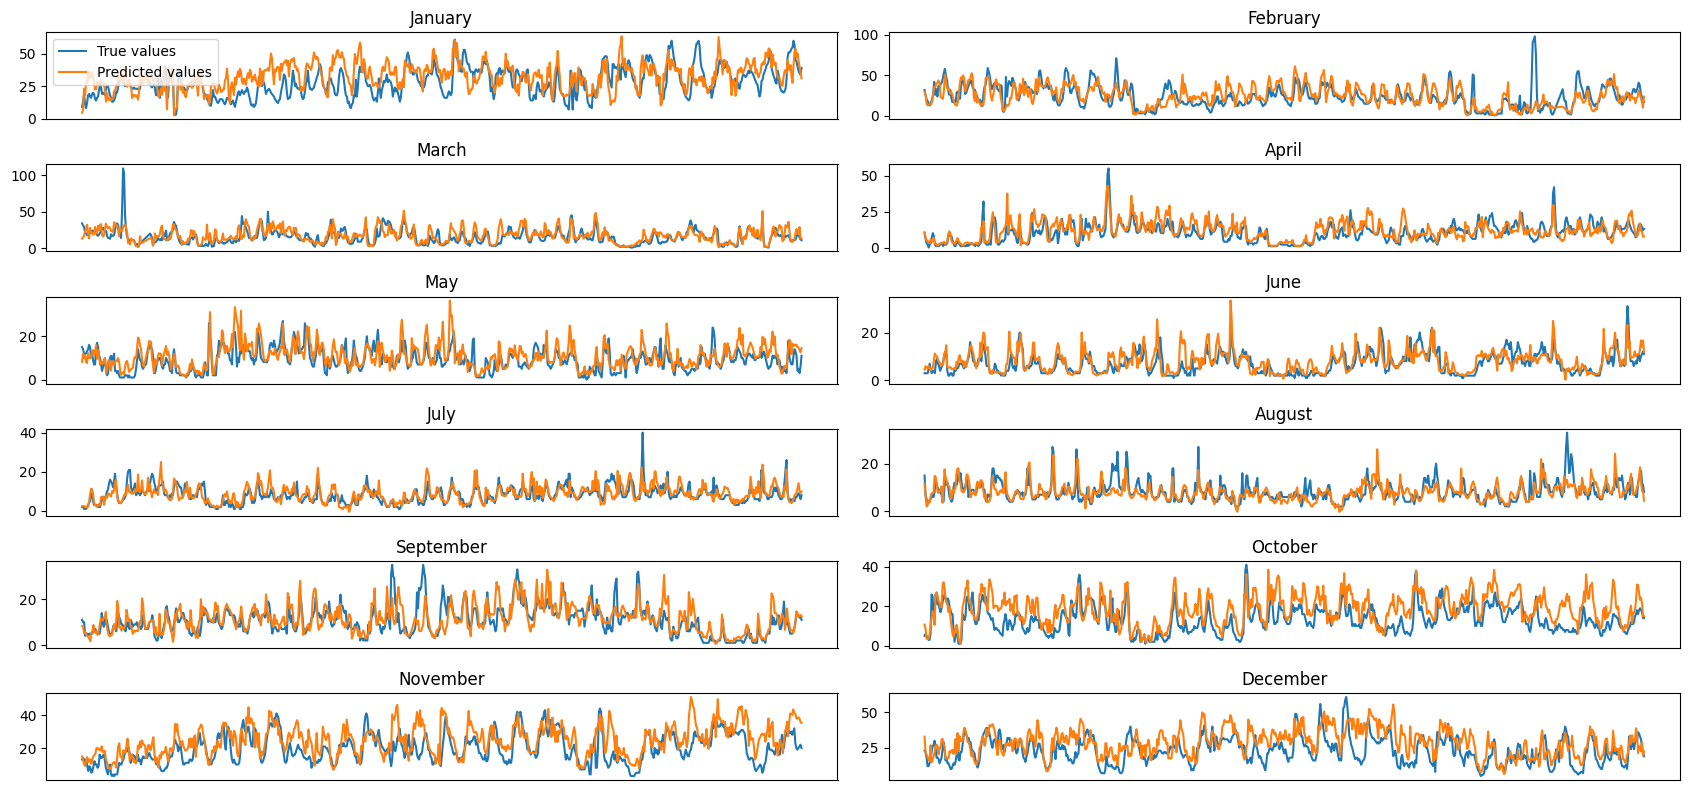

root_mean_squared_error: 0.6104734476041035
r2_score: 0.4706853552442425
mean_absolute_error: 0.42220022887588865
huber: 0.0673292949795723


In [237]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [238]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [239]:
bn_ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_params, bn_ffnn_train_params, False)

In [240]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

In [241]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2 BatchNorm'] = (build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

##### *Testing*

In [242]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN'

In [243]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_model.fit(
    train_sets[station][agent]['x'], 
    train_sets[station][agent]['y'], 
    **hour_models[selected_ffnn][2]
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5342
Epoch 2/10
1335/1335 [==============================] - 9s 6ms/step - loss: 0.5205
Epoch 3/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5103
Epoch 4/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5147
Epoch 5/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5343
Epoch 6/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5424
Epoch 7/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5504
Epoch 8/10
1335/1335 [==============================] - 7s 6ms/step - loss: 0.5574
Epoch 9/10
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5631
Epoch 10/10
274/274 [==============================] - 1s 3ms/step


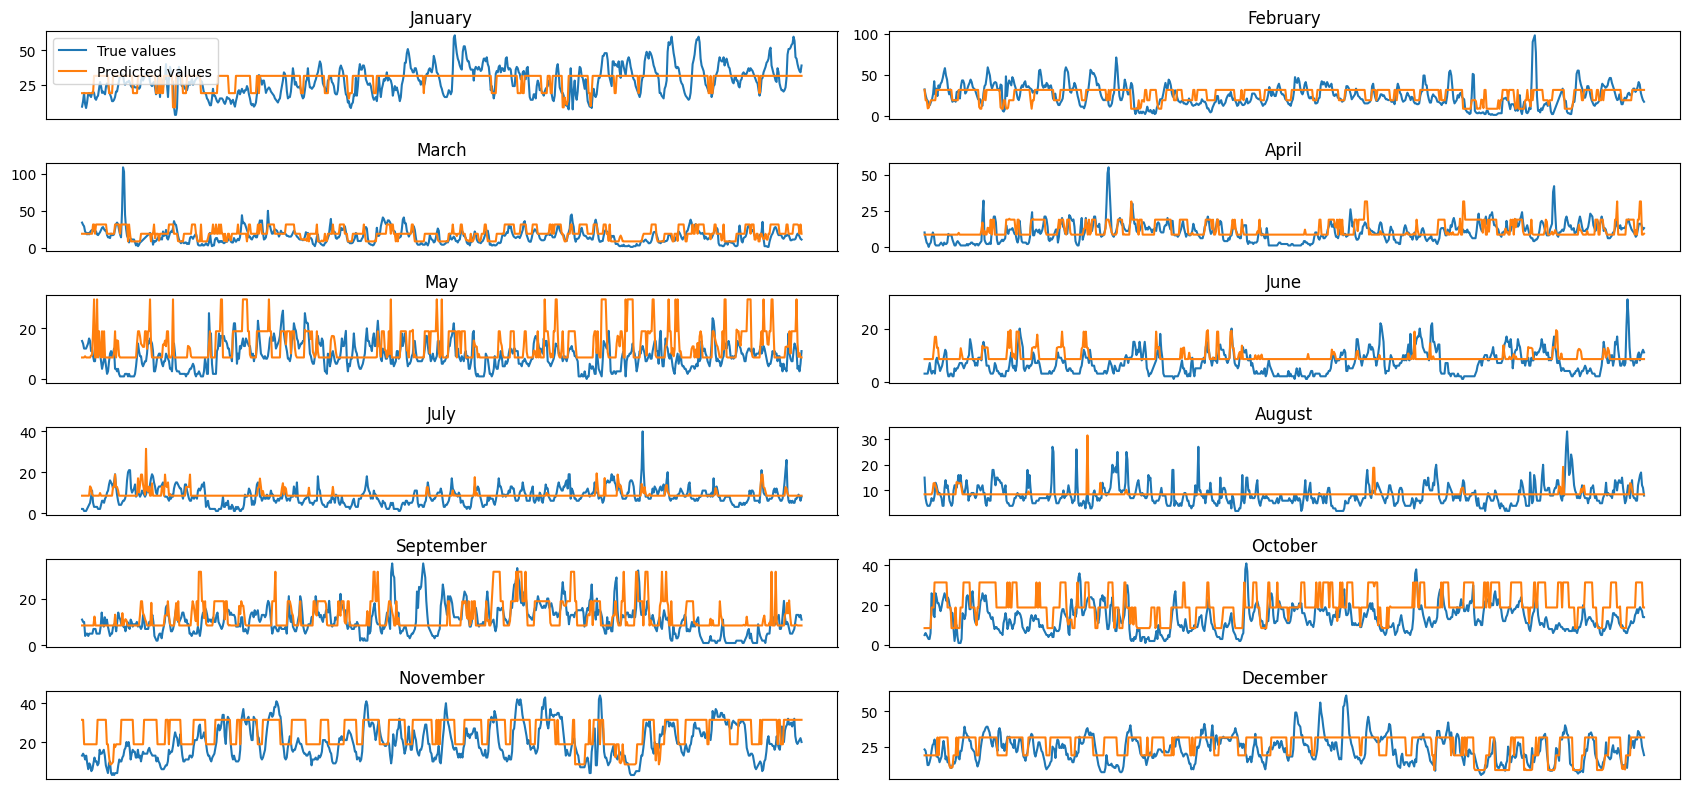

root_mean_squared_error: 0.6721187558737782
r2_score: 0.35838814278045894
mean_absolute_error: 0.5056750653329075
huber: 0.08290666341781616


In [244]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Conv1d

##### *Models*

In [245]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [246]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [247]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [248]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [249]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
conv_X_train, conv_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [250]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_model.fit(
    conv_X_train, 
    conv_y_train, 
    **hour_models[selected_conv][2])
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

Epoch 1/10
601/601 [==============================] - 2s 2ms/step - loss: 0.4151
Epoch 2/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3816
Epoch 3/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3721
Epoch 4/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3605
Epoch 5/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3555
Epoch 6/10
601/601 [==============================] - 2s 2ms/step - loss: 0.3487
Epoch 7/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3433
Epoch 8/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3376
Epoch 9/10
601/601 [==============================] - 1s 2ms/step - loss: 0.3341
Epoch 10/10
274/274 [==============================] - 0s 1ms/step


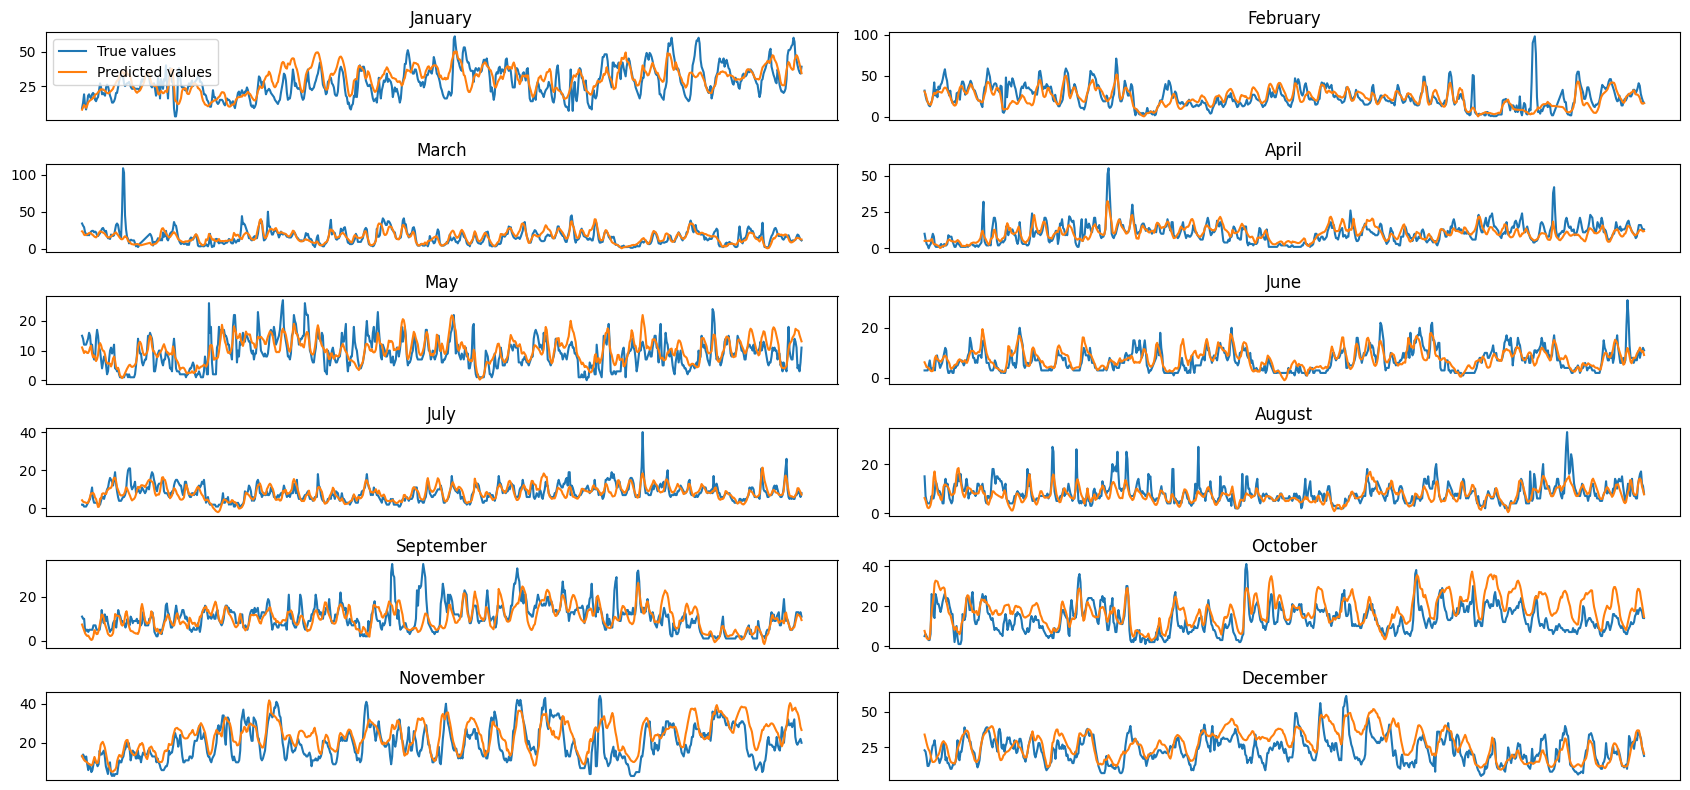

root_mean_squared_error: 0.519385776810521
r2_score: 0.6168573871806073
mean_absolute_error: 0.34944450013957357
huber: 0.05298426374793053


In [251]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

### **Daily Models**

In [252]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [253]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [254]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [255]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [256]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(train_sets[station][agent]['x'], train_sets[station][agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

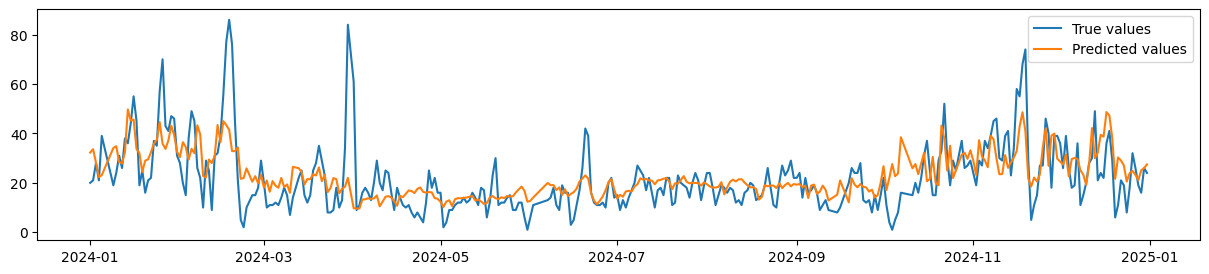

root_mean_squared_error: 0.7279071675442713
r2_score: 0.4134890162799266
mean_absolute_error: 0.5150410915573387
huber: 0.08509470522403717


In [261]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [ ]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [ ]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing*

In [262]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [263]:
validation_ratio = 0.1

X_train, y_train = train_sets[station][agent]['x'], train_sets[station][agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.62924
[1]	validation_0-mae:0.61152
[2]	validation_0-mae:0.59745
[3]	validation_0-mae:0.58339
[4]	validation_0-mae:0.57145
[5]	validation_0-mae:0.56061
[6]	validation_0-mae:0.54944
[7]	validation_0-mae:0.53948
[8]	validation_0-mae:0.53163
[9]	validation_0-mae:0.52671
[10]	validation_0-mae:0.52242
[11]	validation_0-mae:0.51776
[12]	validation_0-mae:0.51336
[13]	validation_0-mae:0.50815
[14]	validation_0-mae:0.50704
[15]	validation_0-mae:0.50191
[16]	validation_0-mae:0.49605
[17]	validation_0-mae:0.49336
[18]	validation_0-mae:0.49187
[19]	validation_0-mae:0.48840
[20]	validation_0-mae:0.48644
[21]	validation_0-mae:0.48337
[22]	validation_0-mae:0.48386
[23]	validation_0-mae:0.48298
[24]	validation_0-mae:0.48159
[25]	validation_0-mae:0.47803
[26]	validation_0-mae:0.47628
[27]	validation_0-mae:0.47439
[28]	validation_0-mae:0.47306
[29]	validation_0-mae:0.47320
[30]	validation_0-mae:0.47300
[31]	validation_0-mae:0.47129
[32]	validation_0-mae:0.46947
[33]	validation_0-ma

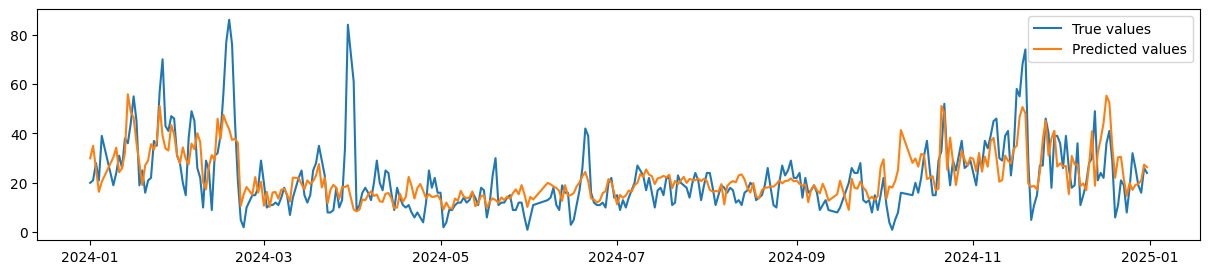

root_mean_squared_error: 0.7114868969067037
r2_score: 0.43965181357450334
mean_absolute_error: 0.4934812687036352
huber: 0.08110333234071732


In [264]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [267]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [268]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [269]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

In [270]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_model.fit(
    train_sets[station][agent]['x'], 
    train_sets[station][agent]['y'], 
    **daily_models[selected_daily_ffnn][2]
    )
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
55/55 [==============================] - 1s 7ms/step - loss: 0.6090
Epoch 2/20
55/55 [==============================] - 0s 6ms/step - loss: 0.5429
Epoch 3/20
55/55 [==============================] - 0s 5ms/step - loss: 0.5249
Epoch 4/20
55/55 [==============================] - 0s 6ms/step - loss: 0.5181
Epoch 5/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4899
Epoch 6/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4815
Epoch 7/20
55/55 [==============================] - 0s 8ms/step - loss: 0.4819
Epoch 8/20
55/55 [==============================] - 0s 7ms/step - loss: 0.4737
Epoch 9/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4670
Epoch 10/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4567
Epoch 11/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4458
Epoch 12/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4489
Epoch 13/20
55/55 [==============================

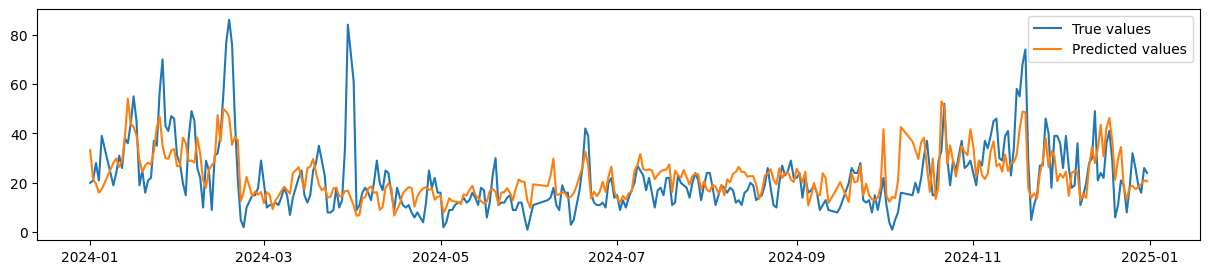

root_mean_squared_error: 0.7310628939556474
r2_score: 0.4083925414606471
mean_absolute_error: 0.523983687159108
huber: 0.08662056177854538


In [271]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

In order to use LSTMs, we need to have sequences/time steps. For the other models, we aggregated the hourly data into a single day, but we could try to go back to hourly inputs aggregated in sequences of 24 hours.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hourly Models

In [275]:
hour_results = train_models(
    hour_models,train_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['O3', 'C6H6', 'CO', 'NO2']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN BatchNorm', 'Feed Forward NN 2', 'Feed Forward NN 2 BatchNorm', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent O3
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> Random Forest Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> XGB Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> XGB Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> LSTM model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> LSTM-masked model:
 >> Training station GIARDIN

We can extract the results from the training phase, and sort the models using their metrics.

In [280]:
hour_extracted_data = training_results_to_dataframe(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
28,GIARDINI MARGHERITA,NO2,Conv1D 2,0.533052,5.964297e-01,0.359649,0.055156
27,GIARDINI MARGHERITA,NO2,Conv1D,0.541689,5.832453e-01,0.368321,0.056649
26,GIARDINI MARGHERITA,NO2,Feed Forward NN 2 BatchNorm,0.548818,5.722038e-01,0.384317,0.059302
29,GIARDINI MARGHERITA,NO2,Conv1D 3,0.568563,5.408676e-01,0.380631,0.059364
19,GIARDINI MARGHERITA,NO2,LSTM,0.575984,5.288041e-01,0.397425,0.062550
17,GIARDINI MARGHERITA,NO2,XGB Regressor,0.582019,5.188784e-01,0.412636,0.065197
15,GIARDINI MARGHERITA,NO2,Random Forest Regressor,0.589980,5.056268e-01,0.438196,0.069710
16,GIARDINI MARGHERITA,NO2,Random Forest Regressor 2,0.590139,5.053603e-01,0.438768,0.069832
22,GIARDINI MARGHERITA,NO2,LSTM 2-masked,0.600185,4.883758e-01,0.406227,0.064366
21,GIARDINI MARGHERITA,NO2,LSTM 2,0.603864,4.820847e-01,0.410533,0.065169


And we can display the best model for each station-agent

In [282]:
display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
28,GIARDINI MARGHERITA,NO2,Conv1D 2,0.533052,0.596430,0.359649,0.055156
14,GIARDINI MARGHERITA,O3,Conv1D 3,0.330739,0.877068,0.247210,0.033586
42,PORTA SAN FELICE,C6H6,Conv1D,0.565663,0.653806,0.352087,0.053831
47,PORTA SAN FELICE,CO,XGB Regressor,0.663283,0.579756,0.509427,0.083722
64,PORTA SAN FELICE,NO2,LSTM,0.960319,-0.709653,0.798018,0.140568
101,VIA CHIARINI,NO2,Feed Forward NN 2 BatchNorm,0.500373,0.593995,0.386899,0.059690
88,VIA CHIARINI,O3,Conv1D 2,0.338074,0.868220,0.254091,0.034764


TODO rerun and write results 

##### **EXAMPLE:** how to eventually try new metrics

In [283]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates

In [284]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = training_results_to_dataframe(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
42,PORTA SAN FELICE,C6H6,Conv1D,0.565663,0.653806,0.352087,0.053831,0.319975
43,PORTA SAN FELICE,C6H6,Conv1D 2,0.567882,0.651085,0.358858,0.055004,0.322490
44,PORTA SAN FELICE,C6H6,Conv1D 3,0.582409,0.633006,0.363449,0.055925,0.339200
38,PORTA SAN FELICE,C6H6,Feed Forward NN,0.999820,-0.081552,0.668315,0.115248,0.999640
40,PORTA SAN FELICE,C6H6,Feed Forward NN 2,0.645244,0.549545,0.401696,0.062970,0.416340
...,...,...,...,...,...,...,...,...
76,VIA CHIARINI,O3,Random Forest Regressor 2,0.376291,0.836742,0.288875,0.041033,0.141595
2,GIARDINI MARGHERITA,O3,XGB Regressor,0.375219,0.841779,0.278880,0.039663,0.140790
77,VIA CHIARINI,O3,XGB Regressor,0.366556,0.845080,0.274106,0.038887,0.134364
3,GIARDINI MARGHERITA,O3,XGB Regressor 2,0.387892,0.830912,0.291799,0.041766,0.150460


### Daily Models

In [285]:
daily_results = train_models(
    daily_models, train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Random Forest Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN BatchNorm model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
Agent PM2.5
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
> Random Forest Re

In [286]:
daily_extracted_data = training_results_to_dataframe(daily_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,0.725913,0.416699,0.510526,0.084287,0.526949
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.727907,0.413489,0.515041,0.085095,0.529849
2,GIARDINI MARGHERITA,PM10,Feed Forward NN,0.732965,0.405309,0.509788,0.083839,0.537238
3,GIARDINI MARGHERITA,PM10,Feed Forward NN BatchNorm,0.740779,0.392562,0.518227,0.085451,0.548754
6,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.718380,0.488120,0.487651,0.079489,0.516069
4,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor,0.726860,0.475963,0.508817,0.083398,0.528325
7,GIARDINI MARGHERITA,PM2.5,Feed Forward NN BatchNorm,0.729101,0.472726,0.504995,0.082829,0.531589
5,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,0.733609,0.466187,0.511831,0.084045,0.538182
11,PORTA SAN FELICE,PM10,Feed Forward NN BatchNorm,0.697763,0.518300,0.466220,0.075731,0.486873
9,PORTA SAN FELICE,PM10,Random Forest Regressor 2,0.720149,0.486896,0.497282,0.081205,0.518614


In [287]:
display(daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber,mean_squared_error
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,0.725913,0.416699,0.510526,0.084287,0.526949
6,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.718380,0.488120,0.487651,0.079489,0.516069
11,PORTA SAN FELICE,PM10,Feed Forward NN BatchNorm,0.697763,0.518300,0.466220,0.075731,0.486873
15,PORTA SAN FELICE,PM2.5,Feed Forward NN BatchNorm,0.652718,0.586955,0.448850,0.071873,0.426041
17,VIA CHIARINI,PM10,Random Forest Regressor 2,0.849094,0.301802,0.647816,0.110745,0.720961
